In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install timm
!pip install -qq albumentations==1.0.3
!pip install torchmetrics
!pip install transformers

     |████████████████████████████████| 376 kB 28.5 MB/s 
     |████████████████████████████████| 98 kB 6.9 MB/s 
     |████████████████████████████████| 47.7 MB 2.5 MB/s 
     |████████████████████████████████| 332 kB 19.5 MB/s 
     |████████████████████████████████| 3.4 MB 14.6 MB/s 
     |████████████████████████████████| 3.3 MB 42.0 MB/s 
     |████████████████████████████████| 61 kB 558 kB/s 
     |████████████████████████████████| 895 kB 58.1 MB/s 
     |████████████████████████████████| 596 kB 55.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
!apt-get install p7zip-full
!p7zip -d /content/drive/MyDrive/MPIII2/allimages.7z /content/

Reading package lists... Done
Building dependency tree       
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-6).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.

7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/drive/MyDrive/MPIII2/                                        1 file, 53955804 bytes (52 MiB)

Extracting archive: /content/drive/MyDrive/MPIII2/allimages.7z
--
Path = /content/drive/MyDrive/MPIII2/allimages.7z
Type = 7z
Physical Size = 53955804
Headers Size = 313213
Method = Copy
Solid = -
Blocks = 34062

  0%      2% 917          4% 1386 - allimages/11296.jpg                               

In [ ]:
len(os.listdir('/content/allimages'))

34062

In [ ]:
#import the libraries.
import matplotlib.pyplot as plt
import math
import os
import numpy as np
from PIL import Image
import string
import pandas as pd

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

# import albumentations
# from albumentations.pytorch.transforms import ToTensorV2

from torchmetrics import AveragePrecision, Recall, F1
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score

from tqdm.auto import tqdm
import functools

from transformers import (AutoModel, AutoTokenizer, 
                          AutoModelForSequenceClassification)
 

In [ ]:
class EmotionSet(Dataset):

  def __init__(self, image_paths, labels, transform=None):
    self.image_paths = image_paths
    self.labels = labels
    self.transform = transform

    self.__label_dict = {
      'angry' : 0,
      'disgust' : 1,
      'fear' : 2,
      'happy' : 3,
      'neutral' : 4,
      'sad' : 5,
      'surprise' : 6
    }

  def __len__(self):
    return len(self.image_paths)

  def __getitem__(self, index):
    img = np.array(Image.open(self.image_paths[index]))
    img = (img - 127.5)/127.5
    if self.transform is not None:
      img = self.transform(image=img)['image']
    img = torch.tensor(img).float()

    label = torch.tensor(self.__label_dict[self.labels[index]]).int()

    return (img, label)

In [ ]:
class EmotionNet(nn.Module):

  def __init__(self, out_features, drop_prob=0.2):
    super().__init__()

    self.cnn_layers = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, stride=1, padding=1), #48, 48, 4.
        nn.MaxPool2d(kernel_size=2, stride=2), #24, 24, 4.
        nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3, stride=1, padding=1), #24, 24, 8.
        nn.MaxPool2d(kernel_size=2, stride=2), #12, 12, 8.
        nn.Conv2d(in_channels=8, out_channels=12, kernel_size=3, stride=1, padding=1), #12, 12, 12
        nn.MaxPool2d(kernel_size=2, stride=2), #6, 6, 12.
    )

    self.clf_head = nn.Sequential(
      nn.Linear(6*6*12, 128),
      nn.ReLU(),
      nn.Dropout(drop_prob),
      nn.Linear(128, out_features)
    )

    self.dropout = nn.Dropout(drop_prob)

  def forward(self, image):
    img_feats = self.cnn_layers(image)
    img_feats = img_feats.view(img_feats.size(0), -1)
    d_out = self.dropout(img_feats)
    output = self.clf_head(d_out)
    return output

In [ ]:
#metrics.
def calc_precision_recall_f1score(preds, targets):
  targets = targets.detach().cpu().numpy()
  preds = preds.detach().cpu().numpy()
  prf = precision_recall_fscore_support(targets, preds)
  return prf

#device.
def select_device():
  if torch.cuda.is_available():
      return torch.device('cuda')
  device = torch.device('cpu')

In [ ]:
def cvt_classes(outputs):
  outputs = torch.nn.functional.softmax(outputs)
  outputs = outputs.detach().cpu().numpy()
  outputs = outputs.argmax(axis=1)
  return torch.tensor(outputs).int()

def train_fn(train_loader, model, loss_fn, optimizer, epoch, device, scheduler=None):
    model.train()
    stream = tqdm(train_loader)
    loss_val = 0
    final_loss = 0

    for i, (image, target) in enumerate(stream, start=1):
        image = image.to(device, non_blocking=True)
        target = target.to(device, non_blocking=True).float().view(-1, 1)
        target = target.squeeze(1)
        target = target.type(torch.LongTensor)

        output = model(image)

        loss = loss_fn(output, target)
        loss_val += loss.item()
        final_loss = loss_val/i
        stream.set_description(f"Epoch {epoch:02}. Train. Loss {final_loss}")

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    return final_loss

def validation_fn(validation_loader, model, loss_fn, epoch, device):
    model.eval()
    stream = tqdm(validation_loader)
    final_targets = []
    final_outputs = []
    loss_val = 0
    final_loss = 0
    out_st, tar_st = None, None
    
    with torch.no_grad():
        for i, (image, target) in enumerate(stream, start=1):
            image = image.to(device, non_blocking=True)
            target = target.to(device, non_blocking=True).float().view(-1, 1)
            target = target.squeeze(1)
            target = target.type(torch.LongTensor)
    
            output = model(image)

            loss = loss_fn(output, target)
            loss_val += loss.item()
            final_loss = loss_val/i

            # outputs = cvt_classes(output)
            # if out_st is None:
            #   out_st, tar_st = outputs.squeeze(1), target
            # else:
            #   out_st, tar_st = torch.cat([out_st, outputs.squeeze(1)]), torch.cat([tar_st, target])
            # accuracy = accuracy_score(out_st, tar_st)
            stream.set_description(f"Valid. Loss {final_loss}")
            
            target = (target.detach().cpu().numpy()).tolist()
            output = (output.detach().cpu().numpy()).tolist()
            
            final_targets.extend(target)
            final_outputs.extend(output)

    return final_loss, torch.tensor(final_targets), torch.tensor(final_outputs)

In [ ]:
EPOCHS = 50
device = select_device()

def get_dataset(df, images, state='training'):
    ids = list(df['Name'])
    image_paths = [os.path.join(images, idx) for idx in ids]
    target = df['Class'].values
    # if state == 'training':
    #     transform = train_transform_object(48)
    # elif state == 'validation' or state == 'testing':
    #     transform = valid_transform_object(48)
    # else:
    transform = None
    return EmotionSet(image_paths, target, transform)

train = pd.read_csv("/content/drive/MyDrive/MPIII2/train.csv")
val = pd.read_csv("/content/drive/MyDrive/MPIII2/validate.csv")

images = "/content/allimages" #path to the images folder.

train_dataset = get_dataset(train, images)
val_dataset = get_dataset(val, images, state='validation')

def collate_fn(batch):
  images = torch.stack([ex[0] for ex in batch])
  images = images[:, None, :, :]
  labels = torch.stack([ex[1] for ex in batch])
  return images, labels

collate_fn = functools.partial(collate_fn)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=val.shape[0], shuffle=False, collate_fn=collate_fn)

model_params = {
    'out_features' : 7,
    'drop_prob' : 0.2,
}

model = EmotionNet(**model_params)
model = model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-6, amsgrad=False)

train_losses, val_losses = [], []
model_path = os.path.join("/content/drive/MyDrive/MPIII2", 'Custom_model.pth')
model_name = 'Custom_model.pth'
best_loss, best_epoch = math.inf, -1
early_stopping = 4
for epoch in range(EPOCHS):
    train_loss = train_fn(train_loader, model, loss_fn, optimizer, epoch, device)
    val_loss, valid_targets, predictions = validation_fn(val_loader, model, loss_fn, epoch, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    outputs = cvt_classes(predictions)
    accuracy = accuracy_score(outputs, valid_targets)
    print('Accuracy : ', accuracy)

    if val_loss < best_loss:
      if os.path.exists(model_path):
        os.remove(model_path)
      best_loss, best_epoch = val_loss, epoch
      torch.save(model.state_dict(), model_path)
      print('Model saved!!')
    
    if epoch - best_epoch == early_stopping:
      break

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Accuracy :  0.22405929304446978
Model saved!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Accuracy :  0.2330387685290764
Model saved!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Accuracy :  0.24415621436716078
Model saved!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Accuracy :  0.25042759407069554
Model saved!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Accuracy :  0.26225769669327254
Model saved!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Accuracy :  0.27793614595210947
Model saved!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Accuracy :  0.2880558722919042
Model saved!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Accuracy :  0.2993158494868871
Model saved!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Accuracy :  0.30986316989737744
Model saved!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Accuracy :  0.3138540478905359
Model saved!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Accuracy :  0.3164196123147092
Model saved!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Accuracy :  0.32696693272519955
Model saved!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Accuracy :  0.3316704675028506
Model saved!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Accuracy :  0.3291049030786773
Model saved!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Accuracy :  0.33822690992018245
Model saved!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Accuracy :  0.34179019384264536
Model saved!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Accuracy :  0.3429304446978335
Model saved!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Accuracy :  0.34064994298745727
Model saved!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Accuracy :  0.34535347776510833
Model saved!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Accuracy :  0.3490592930444698
Model saved!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Accuracy :  0.350484606613455
Model saved!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Accuracy :  0.3483466362599772
Model saved!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Accuracy :  0.3560433295324972
Model saved!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Accuracy :  0.3523375142531357
Model saved!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Accuracy :  0.3560433295324972
Model saved!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Accuracy :  0.35675598631698974
Model saved!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Accuracy :  0.35675598631698974
Model saved!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Accuracy :  0.3621721778791334
Model saved!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Accuracy :  0.3604618015963512
Model saved!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Accuracy :  0.3613169897377423
Model saved!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Accuracy :  0.3638825541619156
Model saved!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Accuracy :  0.367018244013683
Model saved!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Accuracy :  0.36887115165336376
Model saved!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Accuracy :  0.3707240592930445
Model saved!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Accuracy :  0.3715792474344356
Model saved!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Accuracy :  0.37214937286202965
Model saved!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Accuracy :  0.37457240592930446
Model saved!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Accuracy :  0.3775655644241733
Model saved!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Accuracy :  0.37785062713797035
Model saved!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Accuracy :  0.3805587229190422
Model saved!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Accuracy :  0.37941847206385404
Model saved!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Accuracy :  0.38198403648802737
Model saved!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Accuracy :  0.3814139110604333
Model saved!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Accuracy :  0.3809863169897377
Model saved!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Accuracy :  0.3864025085518814
Model saved!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Accuracy :  0.3879703534777651
Model saved!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Accuracy :  0.3896807297605473
Model saved!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Accuracy :  0.38939566704675027
Model saved!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Accuracy :  0.38982326111744586
Model saved!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Accuracy :  0.3919612314709236
Model saved!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


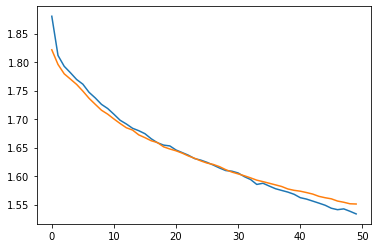

In [ ]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.show()

In [ ]:
val_losses

[1.8216145038604736,
 1.7959123849868774,
 1.779486894607544,
 1.7702230215072632,
 1.7608728408813477,
 1.749173641204834,
 1.7365108728408813,
 1.7259564399719238,
 1.715604543685913,
 1.7087187767028809,
 1.7003077268600464,
 1.6923062801361084,
 1.6849002838134766,
 1.6808232069015503,
 1.6723681688308716,
 1.667493462562561,
 1.6620959043502808,
 1.658915400505066,
 1.6513971090316772,
 1.6476304531097412,
 1.6444255113601685,
 1.6403288841247559,
 1.6353150606155396,
 1.6313135623931885,
 1.6266744136810303,
 1.6228822469711304,
 1.6205027103424072,
 1.6166272163391113,
 1.6113771200180054,
 1.6070997714996338,
 1.603927731513977,
 1.6006550788879395,
 1.5969736576080322,
 1.5929553508758545,
 1.5903356075286865,
 1.5875462293624878,
 1.5847160816192627,
 1.581864833831787,
 1.5775243043899536,
 1.5751312971115112,
 1.573607087135315,
 1.5712134838104248,
 1.5685703754425049,
 1.5645867586135864,
 1.5621364116668701,
 1.560221552848816,
 1.5563082695007324,
 1.5542008876800537,
 